# Basic Strategy

In [6]:
%reload_ext autoreload
%autoreload 2
from init_strategy import generate_basic_strategy
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from env import BaseState, Action
from utils import *



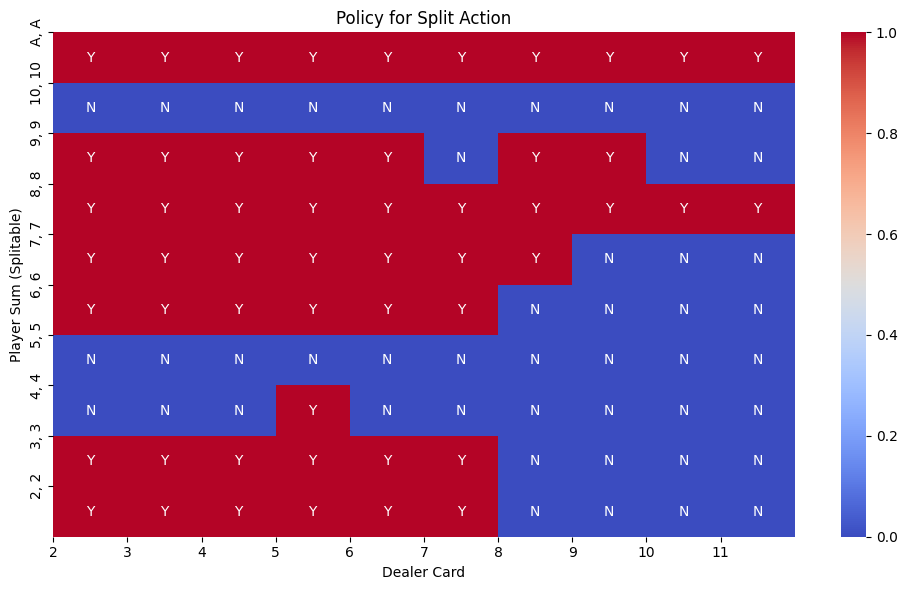

In [7]:
basic_policy = generate_basic_strategy()

# splitting
plot_split_policy(basic_policy)

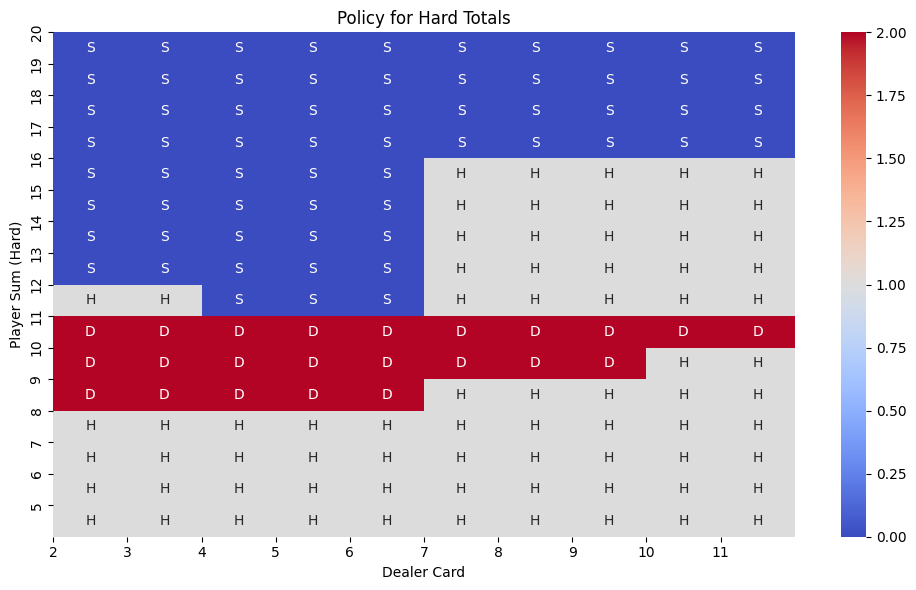

In [8]:
# hard totals
plot_hard_total_policy(basic_policy)

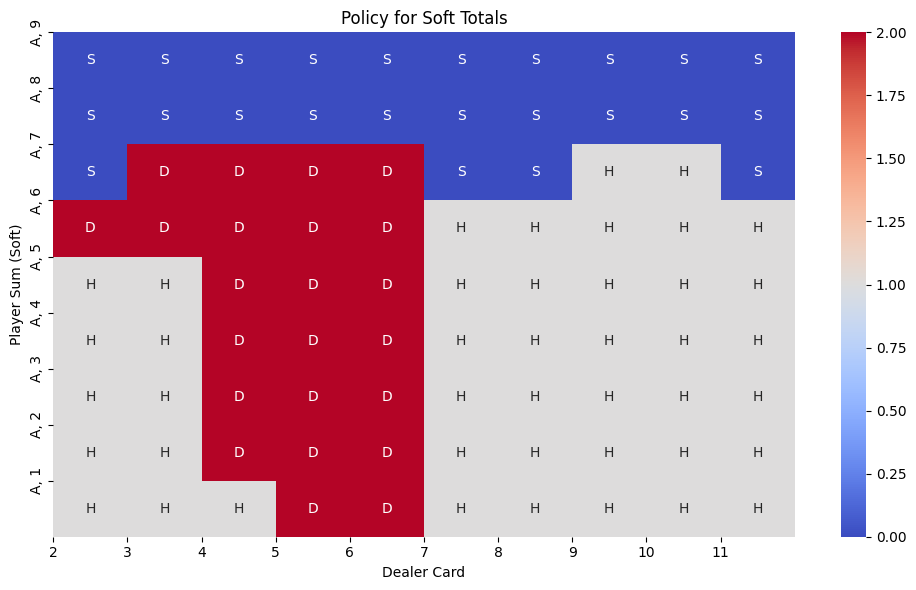

In [9]:
# soft totals
plot_soft_total_policy(basic_policy)

# Load Trained Q and Policy

# Show Optimal Policy
## Split Policy

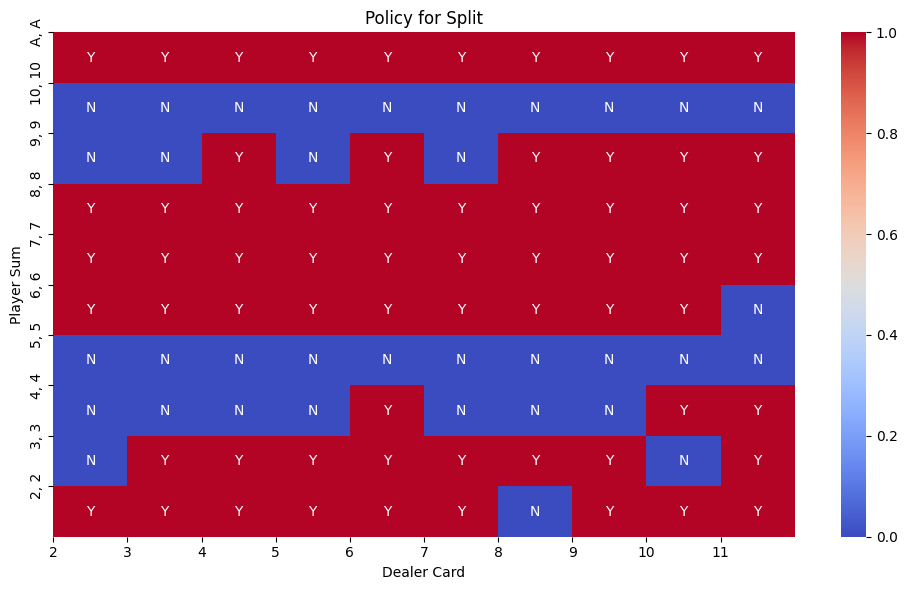

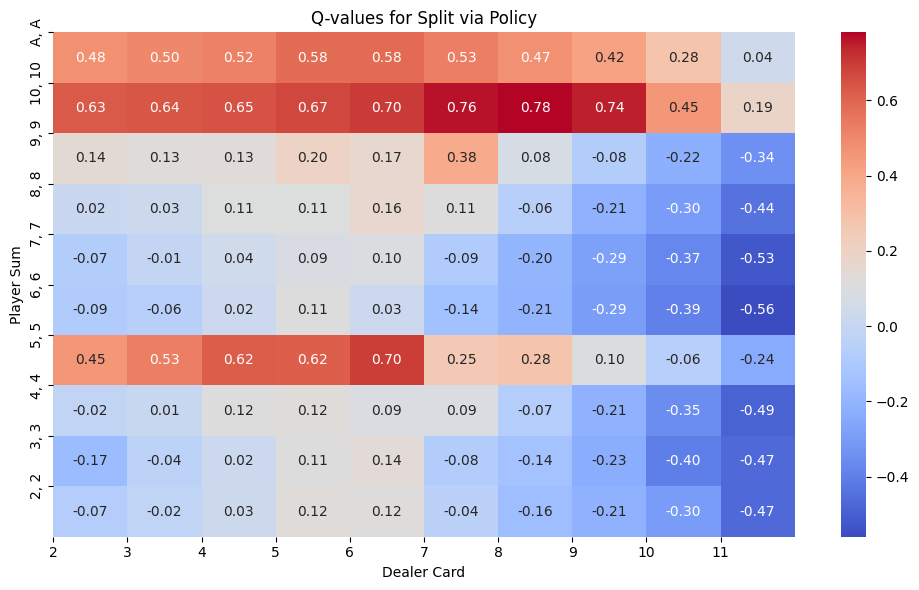

In [66]:
from train_mc import load_agent
policy, Q = load_agent("MCEp_StandHitDoubleSplit_Pretrained2")

# plot_split_policy(policy)
plot_policy_and_Q(Q,policy, ChartName.Split, True)

## Soft Totals
Player has soft Ace

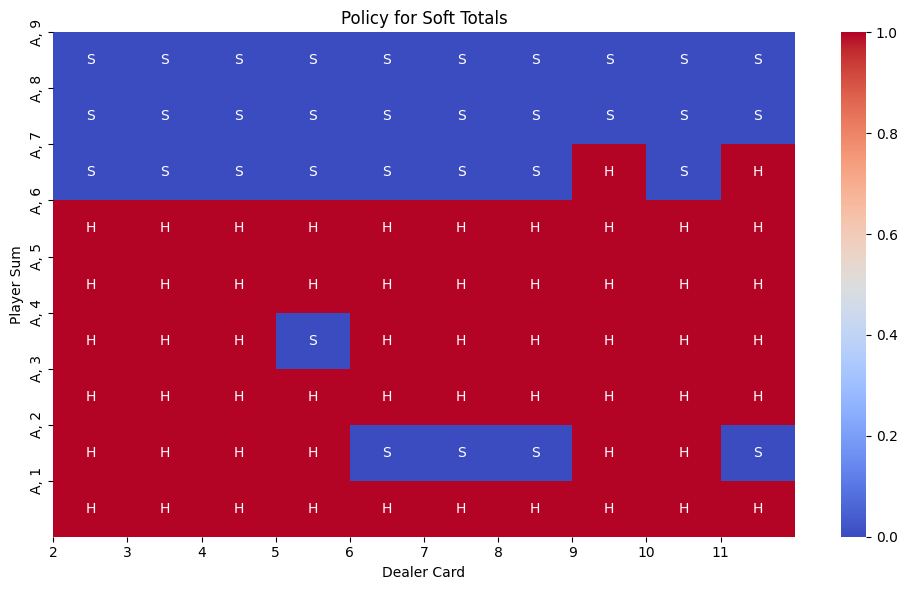

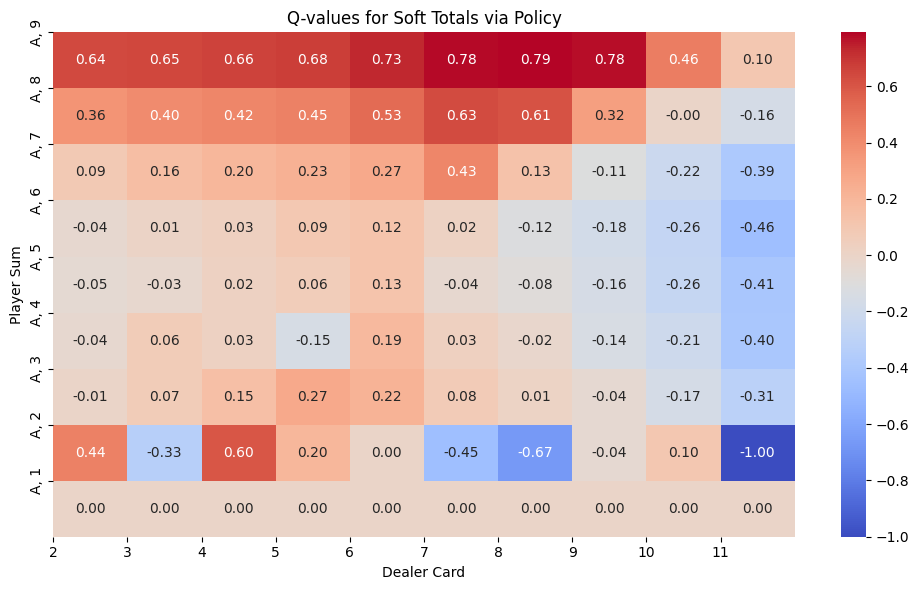

In [67]:
plot_policy_and_Q(Q,policy, ChartName.SoftTotals, can_double=False)

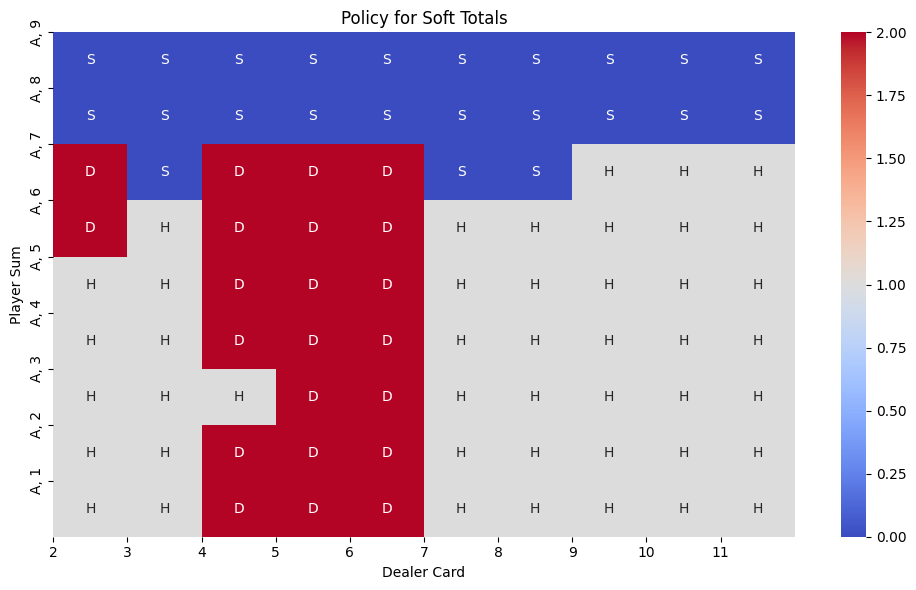

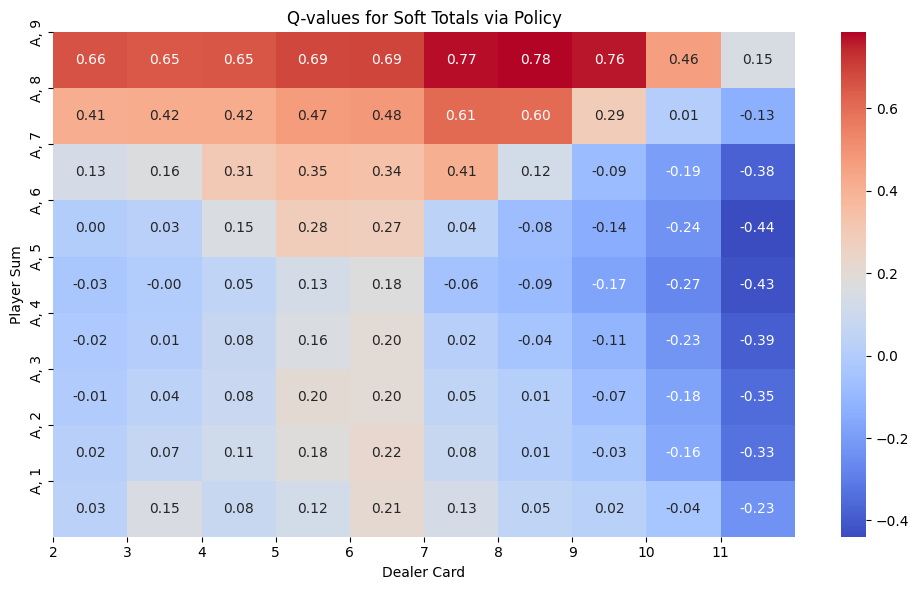

In [68]:
plot_policy_and_Q(Q,policy, ChartName.SoftTotals, can_double=True)

# Hard Totals

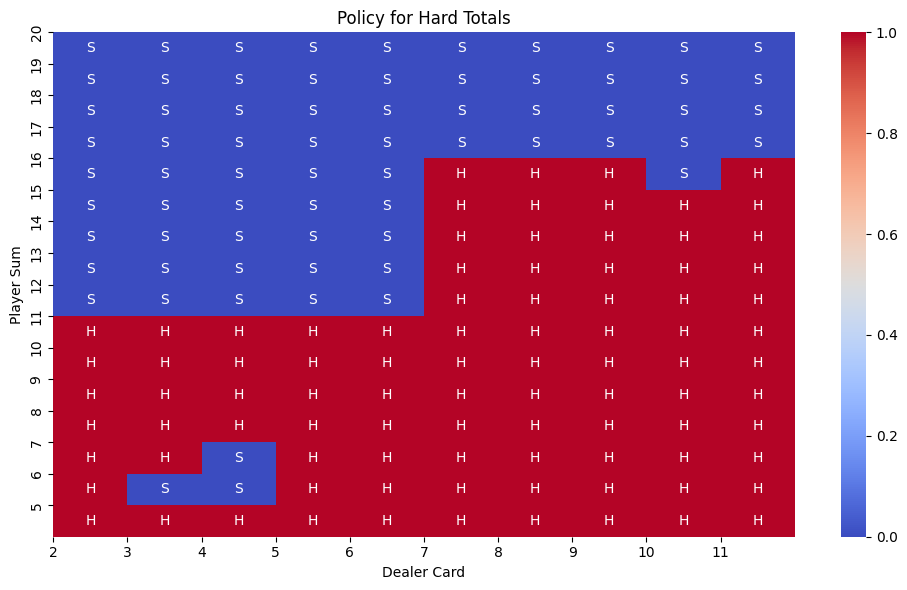

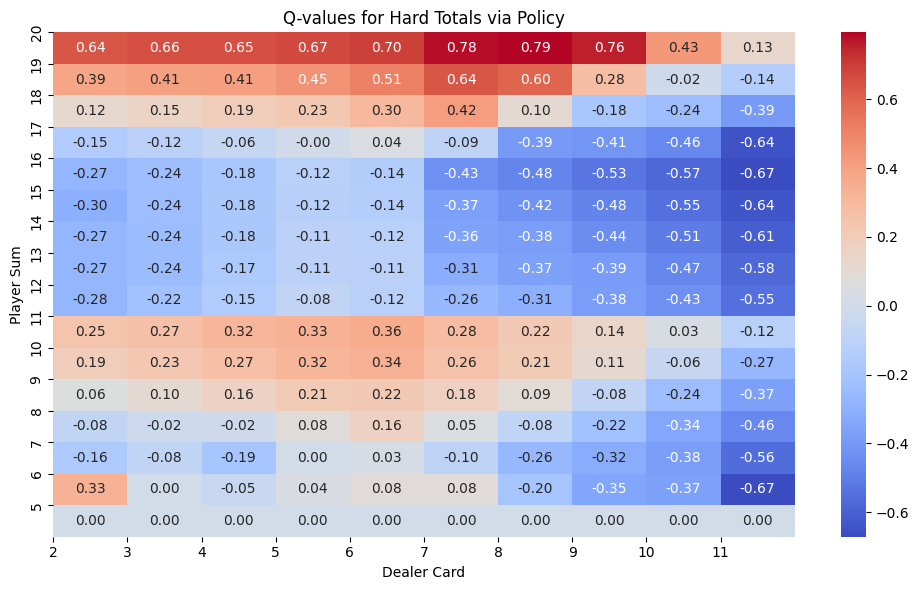

In [69]:
plot_policy_and_Q(Q, policy, ChartName.HardTotals,can_double=False)

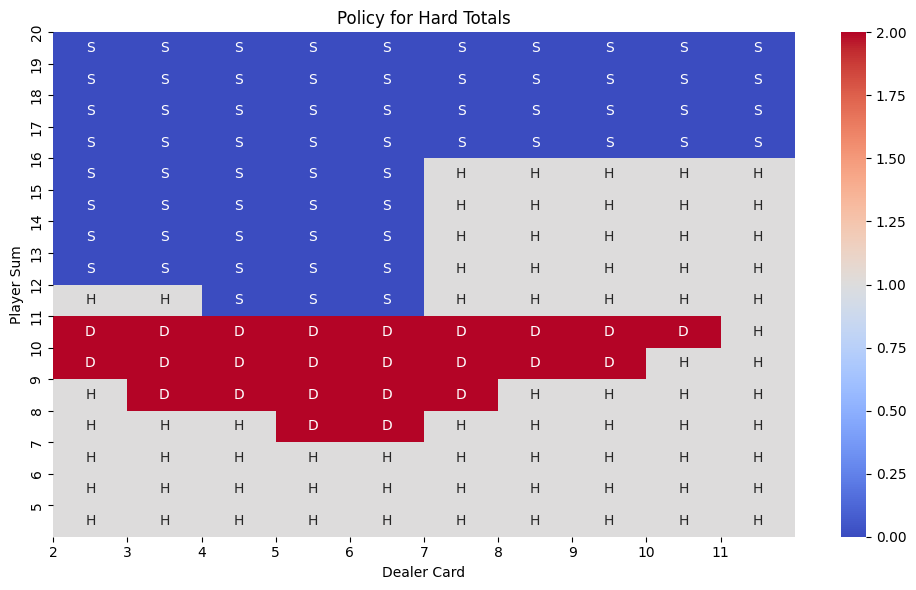

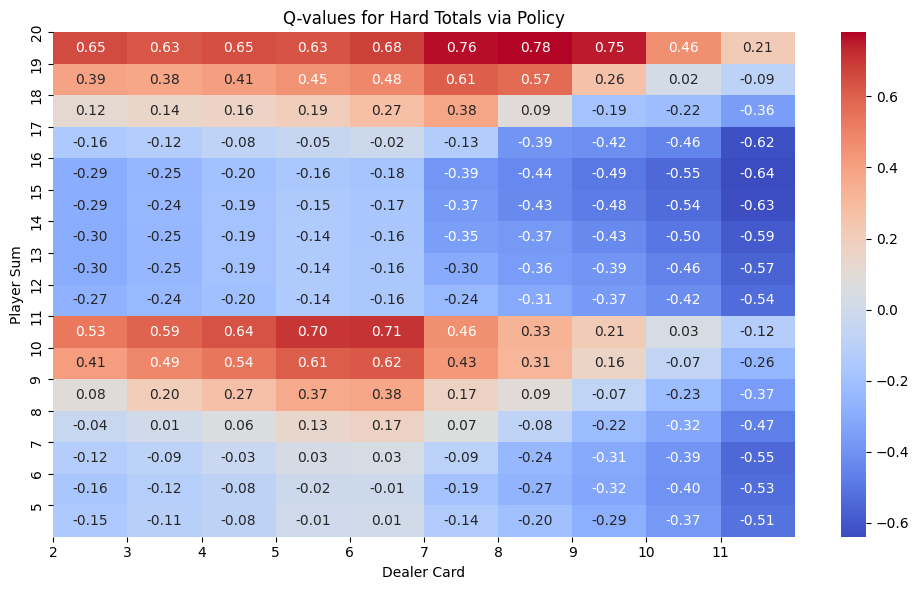

In [70]:
plot_policy_and_Q(Q, policy, ChartName.HardTotals,can_double=True)

# Metrics

## Basiline

In [78]:
from env import BlackjackEnv
from metrics import test_basic_strategy, test, Metric



In [ ]:

test_basic_strategy()

In [ ]:
from deck import NormalDeck
mcep_p_policy, mcep_p_Q = load_agent("MCEp_StandHitDoubleSplit_Pretrained2")

env = BlackjackEnv(given_draw_card=NormalDeck(1).deal_card)
metrics = test(env, mcep_p_policy, 2000000)

print(metrics)

100%|██████████| 2000000/2000000 [00:23<00:00, 84469.35it/s]


--- Game Metrics ---
Episodes Played: 2060773
Blackjack Rate: 4.6284%
Win Rate: 43.7141%
Draw Rate: 8.6094%
Loss Rate: 47.6765%
Double Down Win Rate: 6.0245%
Double Down Loss Rate: 4.1664%
Average Gain per Episode: 0.2098%



In [82]:

q_policy, q_Q = load_agent("DoubleQLearningStandHitDoubleSplit")
metrics = Metric()
for i in range(5):
    m = test(env, q_policy, 2_000_000)
    metrics.AvgGain+=m.AvgGain
    metrics.WinRate+=m.WinRate
    metrics.DrawRate+=m.DrawRate
    metrics.LossRate+=m.LossRate
    metrics.DoubleLossRate +=m.DoubleLossRate
    metrics.DoubleWinRate+=m.DoubleWinRate

metrics.WinRate/=5
metrics.AvgGain/=5
metrics.DrawRate/=5
metrics.LossRate/=5
metrics.DoubleLossRate/=5
metrics.DoubleWinRate/=5
print(metrics)



100%|██████████| 2000000/2000000 [00:25<00:00, 77301.47it/s]


--- Game Metrics ---
Episodes Played: 0
Blackjack Rate: 0.0000%
Win Rate: 43.3535%
Draw Rate: 8.5387%
Loss Rate: 48.1077%
Double Down Win Rate: 4.7802%
Double Down Loss Rate: 3.2041%
Average Gain per Episode: -0.8530%

